# Machine Learning for Signal Processing
### (ENGR-E 511)
### Homework 4

## Problem 1: kNN Source Separation

### Initializing the required libraries

In [1]:
# Importing all Required Libraries
import os
import numpy as np
import librosa as lb
import scipy.io
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
import cv2

In [2]:
#Loading audio files
trs, sr = np.array(lb.load( 'E:/JupiterNotebook/data_hw_4/trs.wav', sr = None),dtype=object)
trn, sr = np.array(lb.load( 'E:/JupiterNotebook/data_hw_4/trn.wav', sr = None),dtype=object)
x_nmf, sr = np.array(lb.load( 'E:/JupiterNotebook/data_hw_4/x_nmf.wav', sr = None),dtype=object)

#Cheking Data
print(trs.shape,trn.shape,x_nmf.shape)

(506166,) (506166,) (66560,)


In [3]:
#Calculating STFT
trs_stft=lb.core.stft(trs)
trn_stft=lb.core.stft(trn)
x_nmf_stft=lb.core.stft(x_nmf)

S = trs_stft[:513,:]
N = trn_stft[:513,:]
#Cheking Data
print(S.shape, N.shape)

(513, 989) (513, 989)


In [4]:
# Calculating G By Affing S and N
G = S + N 
G.shape
abs_G = np.abs(G)

x_nmf_conj=x_nmf_stft[:513,:]
x_nmf_mag=np.abs(x_nmf_conj)

In [5]:
#using a binary (0 or 1) masking matrix B
AS = np.abs(S) > np.abs(N)
B = AS.astype(int)

print(B)
print(B.shape)

[[1 1 1 ... 1 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
(513, 989)


In [6]:
# KNN function to calculate nearest neighbour
def KNN(G, Y, B, k):
    #Initialising Matrix
    Dist = np.zeros(shape=(Y.shape[1], G.shape[1]))
    for i in range(Y.shape[1]):  
        for j in range(G.shape[1]):  
            dist = np.sqrt(np.sum(np.square(Y[:, i] - G[:, j])))
            Dist[i][j] = dist

    #Sorting
    sort_dist = Dist.argsort()

    index_K = sort_dist[:, 0:k]

    rec_mt = np.zeros((Y.shape[1], Y.shape[0]))
    for i in range(0, index_K.shape[0]):
        shr = np.zeros((513, 1))
        for j in range(0, index_K.shape[1]):
            col_index = int(index_K[i][j])
            val = B[:, col_index]
            val = val.reshape((val.shape[0], 1))
            shr = np.hstack((shr, val))
        shr = shr[:, 1:]
        med_k = np.median(shr, axis=1)
        rec_mt[i, :] = med_k

    S_A = np.multiply((rec_mt).T, x_nmf_conj)

    conj_Stest = np.conjugate(S_A)

    for i in range(512, 0, -1):
        S_A = np.vstack((S_A, conj_Stest[i]))

    return S_A

In [7]:
#Calculating KNN
S_A = KNN(abs_G, x_nmf_mag, B, 20)

#Doing istft on output
output = lb.core.istft(S_A)

#Cheking Audio
Audio(output, rate = 16000)

#### I Have tried for the K values 10 to 20 and some other combinations. Decresing K value lower than 10 causes more noise in the audio but incresing the K value over 30 maked your loss of audio density. I founf K 15 to 20 works best for my implementation. 

## Problem 2: Motor Imagery

In [8]:
#Loading Data
eeg = scipy.io.loadmat("E:/JupiterNotebook/data_hw_4/eeg.mat")

In [9]:
print(eeg.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x_te', 'x_train', 'y_te', 'y_train'])


In [10]:
#selecting Relevant Part
x_train = eeg['x_train']
x_test = eeg['x_te']
y_train = eeg['y_train']
y_test = eeg['y_te']

In [11]:
print(x_train.shape, y_train.shape)

(768, 3, 112) (112, 1)


In [12]:
#Intialising Random Seed
np.random.seed(4567890)

In [13]:
N,l,k = 64,110,21

#function for Calculating STFT
def STFT(N,x):
    
    #taking Blackman window
    blackman_win = np.blackman(N)
    blackman_win = blackman_win.reshape(np.shape(blackman_win)[0],1)


    for i in range(0,x.shape[2]):    
        av = np.array([1000000])
        av = av.reshape((av.shape[0],1))
        for j in range(0,x.shape[1]):   
            mat_X = np.zeros((N,1))
            shr1 = x[:,j]
            shr2 = shr1[:,i]  
            for k in range(0,x.shape[0],48):
                if np.shape(shr2[k:N+k])[0] == 64:
                    samp_w = shr2[k:N+k]
                    samp_w = samp_w.reshape(np.shape(samp_w)[0],1)
                    shr_mat = np.multiply(samp_w,blackman_win)
                    shr_mat = shr_mat.reshape(np.shape(shr_mat)[0],1)
                    mat_X = np.hstack((mat_X,shr_mat))
            fin_X = mat_X[:,1:]
            pt_mat_X = fin_X[3:8,:]
            
            for l in range(0,5):
                shr = pt_mat_X[l]
                shr = shr.reshape((shr.shape[0],1))
                av = np.vstack((av,shr))

            if(av[0] == 1000000):
                av = av[1:]
        
        if i == 0:
            shr_out = np.zeros((len(av),1))
            shr_out = np.hstack((shr_out,av))
        else:
            shr_out = np.hstack((shr_out,av))
    
    shr_out = shr_out[:,1:]
    return shr_out

In [14]:
#function for Calculating A (projection Matrix)
def calc_A(l,M):
    
    A = np.random.uniform(-1,1,l)
    for i in range(len(M) - 1):
        A = np.vstack((A,np.random.uniform(-1,1,l)))
        
    inv_shr = 1/(np.array([sum(A[i]) for i in range(len(M))]))
    B = (A * inv_shr[:, np.newaxis]).T    
    return B

In [15]:
def dist(Y,Y_test):
    
    dist = np.zeros((28,112))
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            dist[i][j] = np.count_nonzero(Y_test[:,i]!=Y[:,j])
    
    srt_dist = dist.argsort()
    fin_shr = np.zeros((Y_test.shape[1],Y.shape[1]))
    for i in range(Y_test.shape[1]):
        for j in range(Y.shape[1]):
            shr = srt_dist[i][j]
            fin_shr[i][j] = y_train[shr,0]
            
    return fin_shr

In [16]:
Z = STFT(N,x_train)

Z_test = STFT(N,x_test)
list_i , list_j , list_acc = [],[],[]
for i in range(10,110,5):
    for j in range(3,21,2):
        l = i
        k = j
        
        #Calculating A (projection Matrix)
        A = calc_A(l,Z)

        #Calculating Y and Y sign
        Y=np.dot(A,Z)
        Y_sign=np.sign(Y)
        
        Y_test=np.dot(A,Z_test)
        Y_test_sign=np.sign(Y_test)
        
        in_mat = dist(Y_sign,Y_test_sign)
        k_in_mat = in_mat[:,0:k]        
        
        fin_y_test = np.zeros((y_test.shape[0],1))
        for p in range(0,28):
            fin_y_test[p] = np.median(k_in_mat[p,:])

        shr = 0    
        for p in range(0,28):
            if fin_y_test[p] == y_test[p]:
                shr+=1

        acc = shr/28
        list_i.append(i)
        list_j.append(j)
        list_acc.append(acc)

In [17]:
li_i = np.array(list_i)
li_i = li_i.reshape((li_i.shape[0],1))

li_j = np.array(list_j)
li_j = li_j.reshape((li_j.shape[0],1))

li_acc = np.array(list_acc)
li_acc = li_acc.reshape((li_acc.shape[0],1))

i_stk = np.hstack((li_i,li_j))
fin_stk = np.hstack((i_stk,li_acc))

srt_stk = fin_stk[fin_stk[:,2].argsort()]
rev_stk = srt_stk[::-1]

prt_rev_stk = rev_stk[0:10].argsort()

print("::Accururacy::")
for i in range(len(prt_rev_stk)):
    print('L:\t ' + str(rev_stk[i,0]) + '\t K:\t ' + str(rev_stk[i,1]) + '\t' + str(rev_stk[i,2]))

::Accururacy::
L:	 50.0	 K:	 15.0	0.7142857142857143
L:	 10.0	 K:	 5.0	0.7142857142857143
L:	 10.0	 K:	 11.0	0.7142857142857143
L:	 60.0	 K:	 13.0	0.7142857142857143
L:	 60.0	 K:	 17.0	0.6785714285714286
L:	 105.0	 K:	 7.0	0.6785714285714286
L:	 75.0	 K:	 9.0	0.6785714285714286
L:	 40.0	 K:	 13.0	0.6785714285714286
L:	 70.0	 K:	 5.0	0.6785714285714286
L:	 100.0	 K:	 11.0	0.6785714285714286


#### there is a slight performance drop as my classifier is based on binary variables and bitwise operations, but I do managed to get an accuracy of above 71%.

## Problem 3: Multidimensional Scaling

In [18]:
#Loading Data
mds = scipy.io.loadmat("E:/JupiterNotebook/data_hw_4/MDS_pdist.mat")

In [19]:
print(mds.keys())
#selecting Relevant Part
mds = mds['L']

dict_keys(['__header__', '__version__', '__globals__', 'L'])


In [20]:
# Centering
m = mds - np.mean(mds, axis=1).reshape(-1,1)
X = m - np.mean(m, axis=0)

In [21]:
# function to Calculating Eigen Decomposation
def calc_eigen_decomp(X, num_eigen_vectors):
    itr = 0
    eigen_value = []
    eigen_vector = []
    
    for i in range(num_eigen_vectors):
        w = np.random.rand(X.shape[0], 1)
        
        for itr in range(1000):
            w = np.dot(X, w)
            w = w * (1/np.power(np.sum(np.power(w,2)),0.5))
            
        s1 = np.power(np.sum(np.power(np.dot(w.T, X), 2)), 0.5)
        u1 = np.dot(X.T, w) * (1/s1)
        contrib = s1 * np.dot(w, u1.T)
        
        # Substracting Contribution
        X = X - contrib
        
        eigen_value.append(s1)
        eigen_vector.append(w.reshape(-1,))

    eigen_vector = np.array(eigen_vector)

    return eigen_vector.T, eigen_value

In [22]:
# Calculating Eigen Decomposation
eigen_vector , eigen_value = calc_eigen_decomp(X, 2)
print(eigen_value)
print(eigen_vector)

[1335462.3458225983, 771835.6507978762]
[[ 0.03910923 -0.06840524]
 [ 0.03662902 -0.06654489]
 [ 0.03293468 -0.06660948]
 ...
 [ 0.04337319  0.05697502]
 [ 0.0383456   0.05766009]
 [ 0.03529753  0.05987897]]


In [23]:
lambda_vect = np.diag(eigen_value)
rec_mat = np.dot(eigen_vector, np.sqrt(lambda_vect))

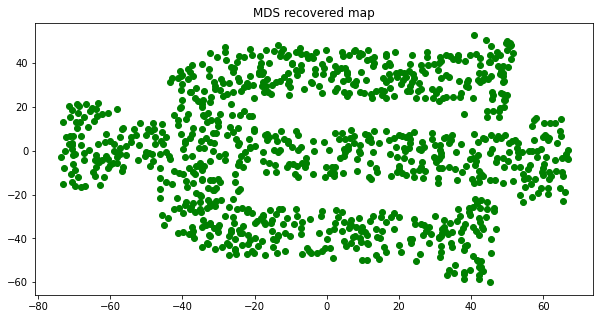

In [24]:
#Plotting Recovred Map
plt.figure(figsize = (10,5))
plt.scatter(rec_mat[:,0], rec_mat[:,1],c='g' )
plt.title('MDS recovered map')
plt.show()

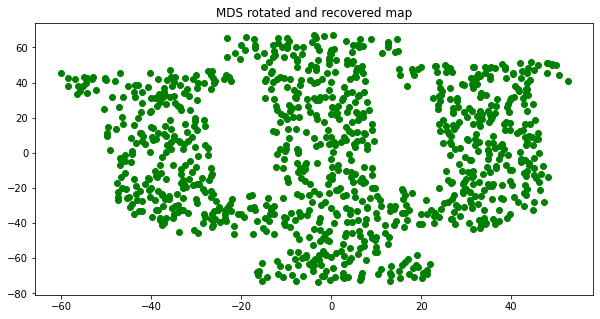

In [25]:
#Plotting Recovred Map and rotating it
plt.figure(figsize = (10,5))
plt.title('MDS rotated and recovered map')
plt.scatter(rec_mat[:,1], rec_mat[:,0],c='g' )
plt.show()

##### We can see that recoverd map is like IU logo.